- https://nbviewer.org/github/maks-sh/scikit-uplift/blob/master/notebooks/uplift_metrics_tutorial.ipynb#uplift@k-=-target-mean-at-k%-in-the-treatment-group---target-mean-at-k%-in-the-control-group
- https://partrita.github.io/posts/python-uplift/

- 다양한 오픈소스에서 uplift와 관련한 모델들을 제공해준다.
- 하지만 이 노트북에서 직접 T-learner 방법론을 진행했다.

In [23]:
import warnings
warnings.filterwarnings('ignore')

# 0. dataset

- This dataset contains 64,000 customers who last purchased within twelve months.
- The customers were involved in an e-mail test:
  - 1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise.
  - 1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise.
  - 1/3 were randomly chosen to not receive an e-mail campaign.
- During a period of two weeks following the e-mail campaign, results were tracked.
- **The task is to tell the world if the Mens or Womens e-mail campaign was successful.**

따라서 treat group은 `Mens E-Mail`을 받았고 control group은 `Womens E-Mail`을 받았다. 이에 따라서 outcome은 `visit` 여부이다. RCT 데이터를 이용하여 treatment를 주면 더 효과적인 그룹 (타겟마케팅)을 알아보자.

In [24]:
import pandas as pd
from sklift.datasets import fetch_hillstrom

bunch = fetch_hillstrom(target_col='visit')

dataset, target, treatment = bunch['data'], bunch['target'], bunch['treatment']
dataset['treatment'] = treatment
dataset['visit'] = target

print(f'Shape of the dataset before processing: {dataset.shape}')

Shape of the dataset before processing: (64000, 10)


In [25]:
dataset.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


In [26]:
mailed_df = dataset.loc[dataset['treatment'] != 'No E-Mail', :].reset_index(drop=True)
print(mailed_df.shape)

(42694, 10)


In [27]:
dummied_df = pd.get_dummies(mailed_df[["zip_code", "channel"]], drop_first=True)

#  필요없는 행을 지운다
feature_vector_df = mailed_df.drop(["history_segment", "zip_code", "channel"], axis=1)
feature_vector_df = feature_vector_df.join(dummied_df)

def treatment_change(x):
    if x == 'Mens E-Mail':
        return 1
    else:
        return 0

feature_vector_df['treatment'] = feature_vector_df['treatment'].map(treatment_change)
feature_vector_df.head()

,recency,history,mens,womens,newbie,treatment,visit,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,0,0,1,0,1,0
1,7,180.65,0,1,1,0,0,1,0,0,1
2,9,675.83,1,0,1,1,0,0,0,0,1
3,2,45.34,1,0,0,0,0,0,1,0,1
4,6,134.83,0,1,0,0,1,1,0,1,0


# 1. 학습하기

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# 학습용, 테스트 데이터 나누기
train_feature_df, test_feature_df \
    = train_test_split(feature_vector_df, test_size=0.5, random_state=0)

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
treat_model = LogisticRegression()
control_model = LogisticRegression()

# treat와 control그룹을 나눈다
treat_is_visit = train_feature_df.loc[train_feature_df['treatment']==1, 'visit']
treat_feature_df = train_feature_df.loc[train_feature_df['treatment']==1, :].drop(['treatment', 'visit'], axis=1)

control_is_visit =  train_feature_df.loc[train_feature_df['treatment']==0, 'visit']
control_feature_df = train_feature_df.loc[train_feature_df['treatment']==0, :].drop(['treatment', 'visit'], axis=1)

# 이들을 각각의 모델을 이용하여 visit 여부를 예측
treat_model.fit(treat_feature_df, treat_is_visit)
control_model.fit(control_feature_df, control_is_visit)

LogisticRegression()

# 2. 모델 평가

In [32]:
treat_control_test_feature_df = test_feature_df.drop(['treatment','visit'], axis=1)

# test 데이터 예측값
treat_score = treat_model.predict_proba(treat_control_test_feature_df)
control_score = control_model.predict_proba(treat_control_test_feature_df)

In [33]:
# uplift score
# visit할 (visit==1) 확률을 이용
# 즉, 고객이 treat 받았을 때의 visit 확률이 treat를 받지 않았을 때의 visit 확률보다 얼마나 큰지
score_list = treat_score[:,1] - control_score[:,1]

In [34]:
result = list(zip(test_feature_df['visit'], test_feature_df['treatment'], score_list))
# score_list가 높은 순서대로 (내림차순) 정렬
result.sort(key=lambda x: x[2], reverse=True)

## 2.1 백분위수 단위로 전환율 확인

In [35]:
import matplotlib.pyplot as plt

In [49]:
result_df = pd.DataFrame()
result_df['visit'] = test_feature_df['visit']
result_df['treatment'] = test_feature_df['treatment']
result_df['uplift_score'] = score_list

result_df = result_df.sort_values('uplift_score', ascending=False).reset_index(drop=True)

# pd.qcut: 동일 갯수로 나누어서 범주를 만든다 (bucket마다 동일한 갯수의 데이터가 들어감)
q = 10
result_df['percentile'] = pd.qcut(result_df['uplift_score'], q, labels=False)

In [50]:
result_df.head()

,visit,treatment,uplift_score,percentile
0,0,0,0.139287,9
1,0,0,0.133194,9
2,1,0,0.132982,9
3,1,1,0.132974,9
4,0,0,0.132790,9


In [56]:
qdf = pd.DataFrame(columns=['treat_visit_rate', 'control_visit_rate'])

for i in range(9, -1, -1):
    percentile_df = result_df.loc[result_df['percentile'] == i, :]
    num_treat = sum(percentile_df['treatment'] == 1)
    num_control = sum(percentile_df['treatment'] == 0)
    num_treat_visit = sum((percentile_df['treatment'] == 1) & (percentile_df['visit'] == 1))
    num_control_visit = sum((percentile_df['treatment'] == 0) & (percentile_df['visit'] == 1))

    idx = f'percentile {(10 - i) * 10}%'
    qdf.loc[idx] =  [num_treat_visit / num_treat, num_control_visit / num_control]

- uplift가 높은 상위 50%에서는 확실히 treat의 효과가 크다고 할 수 있다.
- 하지만 70%, 80% 구간에서는 오히려 역전되기도 한다.
- 따라서 uplift score가 높은 상위 유저들에게만 treat를 해주는게 효과적이다.

Text(0, 0.5, 'visit rate')

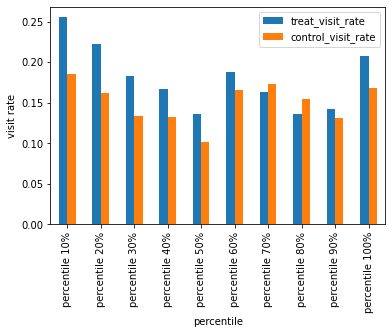

In [57]:
qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("visit rate")

## 2.2 `sklift` 이용

- uplift@k = target mean at k% in the treatment group - target mean at k% in the control group

- How to count uplift@k:
1. sort by predicted uplift
2. select first k%
3. count target mean in the treatment group
4. count target mean in the control group
5. substract the mean in the control group from the mean in the treatment group


In [41]:
from sklift.metrics import uplift_at_k

k = 0.3  

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(test_feature_df['visit'], score_list, test_feature_df['treatment'], strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(test_feature_df['visit'], score_list, test_feature_df['treatment'], strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@30%: 0.0592 (sort groups by uplift together)
uplift@30%: 0.0613 (sort groups by uplift separately)


In [36]:
from sklift.metrics import uplift_by_percentile

uplift_by_percentile(test_feature_df['visit'], score_list, test_feature_df['treatment'], 
                     strategy='overall', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1061,1074,0.255419,0.185289,0.070131,0.013388,0.011856,0.017883
10-20,1009,1126,0.222002,0.161634,0.060368,0.013083,0.010970,0.017074
20-30,1083,1052,0.182825,0.134030,0.048795,0.011745,0.010504,0.015757
30-40,1075,1060,0.167442,0.132075,0.035366,0.011388,0.010399,0.015421
40-50,1026,1109,0.136452,0.101894,0.034559,0.010717,0.009084,0.014049
50-60,1088,1047,0.188419,0.165234,0.023185,0.011855,0.011478,0.016501
60-70,1089,1046,0.163453,0.173040,-0.009587,0.011205,0.011696,0.016198
70-80,1064,1070,0.137218,0.155140,-0.017922,0.010548,0.011068,0.015289
80-90,1067,1067,0.141518,0.131209,0.010309,0.010671,0.010336,0.014856


- 따라서 아래의 경우 대략 상위 50%에는 treat(man mail)이 더 효과적이고 나머지는 treat이 아닌(woman mail)이 더 효과적이라고 할 수 있다. 

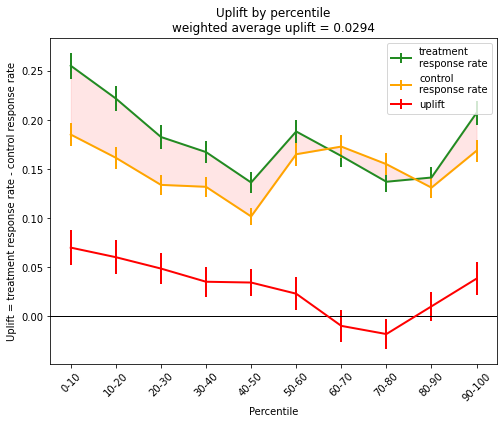

In [37]:
from sklift.viz import plot_uplift_by_percentile
# line plot
plot_uplift_by_percentile(test_feature_df['visit'], score_list, test_feature_df['treatment'], strategy='overall', kind='line');

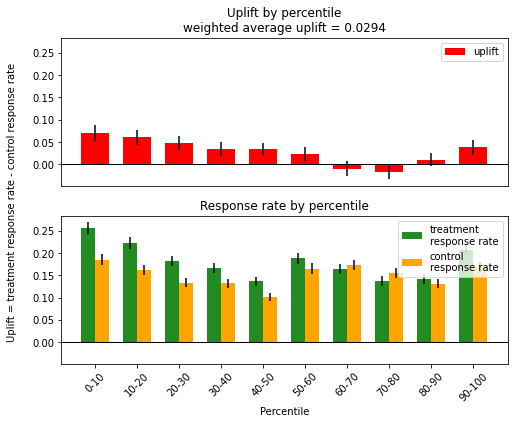

In [38]:
plot_uplift_by_percentile(test_feature_df['visit'], score_list, test_feature_df['treatment'], strategy='overall', kind='bar');